## PCA

We're going to run PCA on efferent and afferent connectivity matrices, so we can look at differences between hippocampal afferent and efferent connectivity. We predict that connections to the hippocampus connect more or less equally across all subregions of the hippocampus, so we should see more principal components, each explaining less variance. Conversely, we predict that connections coming out of the hippocampus are more functionally specialized and thus we should see fewer principal components, with the first few explaining most of the variance--this is because outputs cluster in more distinct patterns (outputs really define the function of a region) and thus the variance in connectivity profiles can be defined by fewer clusters.

In [9]:
import numpy as np
import pandas as pd

In [10]:
df_average = pd.read_csv('../data/average_connectome_data.csv', header=0, index_col=0)

In [11]:
# filter the afferent / efferent based on hippocampal connections, create similarity matrix
hippocampal_regions = np.array(['DG','CA3','CA2','CA1v','CA1d','SUBv','SUBd'])

# FROM hippocampus (efferent)
df_avg_from = df_average[df_average.index.isin(hippocampal_regions)]

# TO hippocampus (afferent)
df_average_t = df_average.T
df_avg_to = df_average_t[df_average_t.index.isin(hippocampal_regions)]

# drop HPC columns
df_avg_from = df_avg_from.drop(hippocampal_regions, axis=1)
df_avg_to = df_avg_to.drop(hippocampal_regions, axis=1)

# filter to only include columns and rows with at least one connection
df_avg_from = df_avg_from.loc[:,df_avg_from.apply(np.count_nonzero, axis=0) >= 1]
df_avg_to = df_avg_to.loc[:,df_avg_to.apply(np.count_nonzero, axis=0) >= 1]

In [12]:
len(df_avg_from.T.index)

165

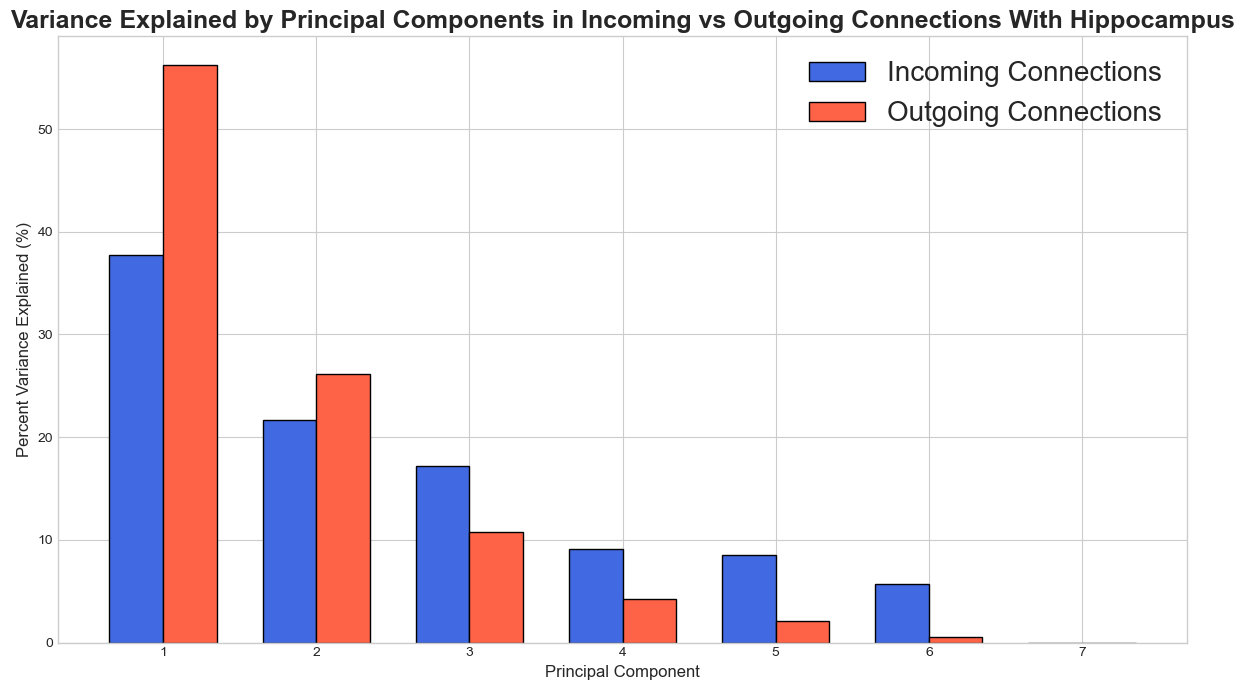

In [53]:
# PCA on efferent/afferent
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# --- 1. Simulate or Load Your Data ---
# Replace this section with your actual data loading logic.
# For example: connectivity_matrix = np.loadtxt('your_matrix.csv', delimiter=',')
# print("Generating sample 392x392 connectivity matrix...")
# connectivity_matrix = np.random.randint(0, 8, size=(392, 392))
# np.fill_diagonal(connectivity_matrix, 0) # No self-connections


# # --- 2. Filter the Datasets ---
# # Define the indices for the first 7 regions (0-6 in Python)
# target_regions_indices = range(7)

# # Dataset A: Outgoing connections FROM regions 1-7.
# # Shape will be (7, 392)
# dataset_A = connectivity_matrix[target_regions_indices, :]

# # Dataset B: Incoming connections TO regions 1-7.
# # We transpose the selection to get a shape of (7, 392)
# dataset_B = connectivity_matrix[:, target_regions_indices].T

# print(f"Shape of Dataset A (Outgoing): {dataset_A.shape}")
# print(f"Shape of Dataset B (Incoming): {dataset_B.shape}")


# --- 3. Standardize the Data ---
# It's a best practice to scale data before running PCA.
scaler = StandardScaler()
dataset_A_scaled = scaler.fit_transform(df_avg_to)
dataset_B_scaled = scaler.fit_transform(df_avg_from)


# --- 4. Perform PCA on Both Datasets ---
# Since each dataset has 7 samples, there can be a maximum of 7 principal components.
n_components = 7
hpc_pca_afferent = PCA(n_components=n_components)
hpc_pca_efferent = PCA(n_components=n_components)

# Fit the PCA models to each dataset
hpc_pca_afferent.fit(dataset_A_scaled)
hpc_pca_efferent.fit(dataset_B_scaled)


# --- 5. Extract Explained Variance ---
# The 'explained_variance_ratio_' attribute gives the proportion of variance.
# Multiply by 100 to convert it to a percentage.
hpc_variance_explained_afferent = hpc_pca_afferent.explained_variance_ratio_ * 100
hpc_variance_explained_efferent = hpc_pca_efferent.explained_variance_ratio_ * 100


# --- 6. Plot the Results (Scree Plot) ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Define the x-axis positions for the bars
component_numbers = np.arange(1, n_components + 1)
bar_width = 0.35

# Create the bar plot for afferent
ax.bar(
    component_numbers - bar_width/2,
    hpc_variance_explained_afferent,
    width=bar_width,
    label='Incoming Connections',
    color='royalblue',
    edgecolor='k'
)

# Create the bar plot for efferent
ax.bar(
    component_numbers + bar_width/2,
    hpc_variance_explained_efferent,
    width=bar_width,
    label='Outgoing Connections',
    color='tomato',
    edgecolor='k'
)


# --- 7. Final Chart Formatting ---
ax.set_xlabel('Principal Component', fontsize=12)
ax.set_ylabel('Percent Variance Explained (%)', fontsize=12)
ax.set_title('Variance Explained by Principal Components in Incoming vs Outgoing Connections With Hippocampus', fontsize=18, weight='bold')
ax.set_xticks(component_numbers) # Ensure integer ticks for each component
ax.legend(fontsize=20)
plt.tight_layout()
plt.savefig('../output/PCA_connectivity_profiles.png')
plt.show()

### Bootstrapping PCA

We want to know if the hippocampal principal components are unique or if they merely reflect more general network structure across the brain. We will boostrap 1000 simulations. For each trial:

- we randomly select 7 non-hippocampal regions and generate afferent/efferent matrices for those selected regions
- We run PCA on the afferent / efferent matrices
- Store PCA metrics in an array

In [30]:
variance_explained_A

array([3.77526912e+01, 2.17006048e+01, 1.71556173e+01, 9.12524918e+00,
       8.53520077e+00, 5.73063685e+00, 4.47286126e-31])

In [31]:
import random

# Assuming your inputs are:
# connectivity_matrix: numpy array of shape (392, 392)
# hippocampal_indices: list or array of 7 indices for hippocampal regions
# target_cols: list or array of 162 indices of the target regions (columns)

num_iterations = 2000

wb_variance_explained_afferent = np.zeros((num_iterations, 7))
wb_variance_explained_efferent = np.zeros((num_iterations, 7))

num_to_select = 7

# 1. Define all regions, exclude hippocampal regions
exclude_set = set(hippocampal_regions)
all_regions = df_average.index.to_numpy()

# 2. Create a list of candidates: strings in A that are NOT in the exclusion set
candidates = [region for region in all_regions if region not in exclude_set]

for i in range(num_iterations):
    # first grab 7 random non-hippocampal regions
    random_selection = random.sample(candidates, num_to_select)

    # construct afferent / efferent connection matrices from random regions
    # FROM random
    df_avg_from_random_sample = df_average[df_average.index.isin(random_selection)]
    
    # TO random
    df_average_t = df_average.T
    df_avg_to_random_sample = df_average_t[df_average_t.index.isin(random_selection)]
    
    # probably want to drop na columns and rows of all NaNs
    spearman_df_from_random_sample = (df_avg_from_random_sample.corr(method='spearman').dropna(axis=0, how='all')).dropna(axis=1, how='all')
    spearman_df_to_random_sample = (df_avg_to_random_sample.corr(method='spearman').dropna(axis=0, how='all')).dropna(axis=1, how='all')

    # Standardize the Data -- best to scale data before running PCA
    scaler = StandardScaler()
    afferent_scaled = scaler.fit_transform(spearman_df_to_random_sample)
    efferent_scaled = scaler.fit_transform(spearman_df_from_random_sample)
    
    # Perform PCA on Both Datasets
    # Since each dataset has 7 samples, there can be a maximum of 7 principal components.
    n_components = 7
    pca_afferent = PCA(n_components=n_components)
    pca_efferent = PCA(n_components=n_components)
    
    # Fit the PCA models to each dataset
    pca_afferent.fit(afferent_scaled)
    pca_efferent.fit(efferent_scaled)

    # store the outputs in arrays
    wb_variance_explained_afferent[i] = pca_afferent.explained_variance_ratio_ * 100
    wb_variance_explained_efferent[i] = pca_efferent.explained_variance_ratio_ * 100

In [32]:
# average variance explained across all 1000 iterations
average_afferent_variance_explained = np.mean(wb_variance_explained_afferent, axis=0)
average_efferent_variance_explained = np.mean(wb_variance_explained_efferent, axis=0)

In [18]:
average_afferent_variance_explained

array([4.73257012e+01, 2.43835480e+01, 1.33874738e+01, 8.03822041e+00,
       4.69014250e+00, 2.17491404e+00, 1.00531894e-28])

In [19]:
variance_explained_A

array([3.77526912e+01, 2.17006048e+01, 1.71556173e+01, 9.12524918e+00,
       8.53520077e+00, 5.73063685e+00, 4.47286126e-31])

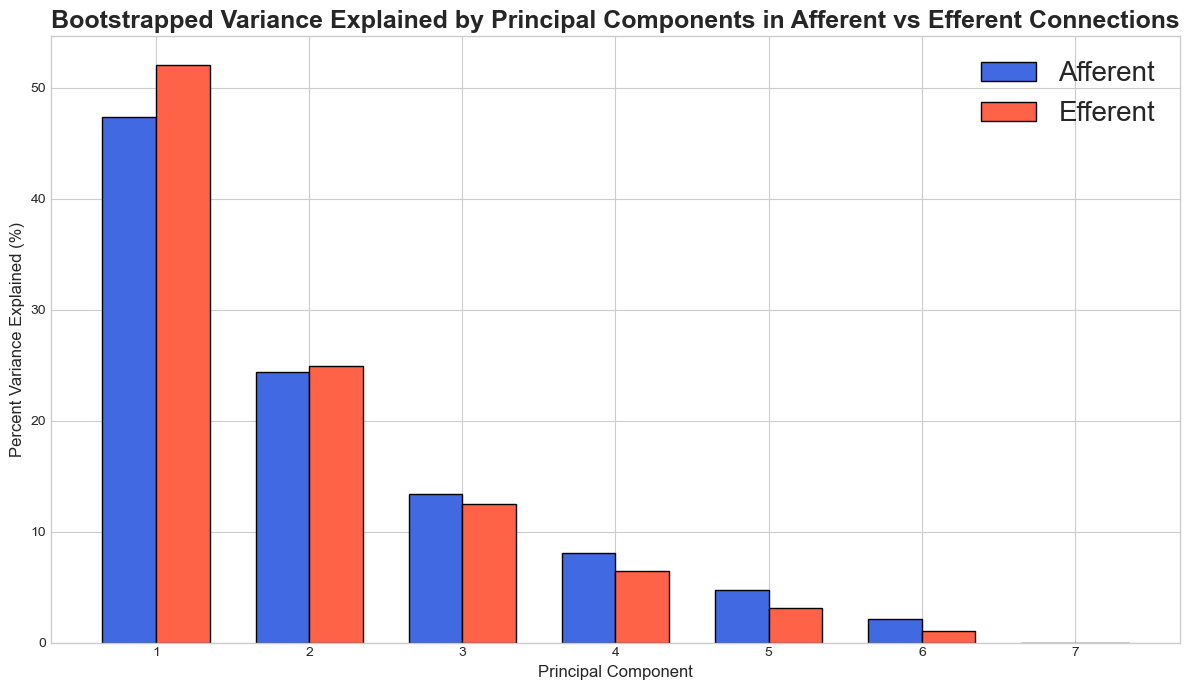

In [55]:
# plot the averages 

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Define the x-axis positions for the bars
component_numbers = np.arange(1, n_components + 1)
bar_width = 0.35

# Create the bar plot for Dataset A (Outgoing profiles)
ax.bar(
    component_numbers - bar_width/2,
    average_afferent_variance_explained,
    width=bar_width,
    label='Afferent',
    color='royalblue',
    edgecolor='k'
)

# Create the bar plot for Dataset B (Incoming profiles)
ax.bar(
    component_numbers + bar_width/2,
    average_efferent_variance_explained,
    width=bar_width,
    label='Efferent',
    color='tomato',
    edgecolor='k'
)


# Final Chart Formatting
ax.set_xlabel('Principal Component', fontsize=12)
ax.set_ylabel('Percent Variance Explained (%)', fontsize=12)
ax.set_title('Bootstrapped Variance Explained by Principal Components in Afferent vs Efferent Connections', fontsize=18, weight='bold')
ax.set_xticks(component_numbers) # Ensure integer ticks for each component
ax.legend(fontsize=20)
plt.tight_layout()

plt.savefig('../output/PCA_bootstrapped_connectivity_profiles.png')
plt.show()

## Run Statistical Tests on Principal Components Between Efferent and Afferent

For the hippocampus efferent and afferent principal components, we find the difference between each component, which we will call the hippocampal connectivity component delta. Then we do the same for the bootstrapped values, which we will call whole brain connectivity component delta. 

Then we calculate the number of times in the bootstrapped values that the whole brain delta exceeds the hippocampal delta.

In [34]:
# difference in hippocampal principal components (efferent - afferent)
hippocampal_component_differences = hpc_variance_explained_efferent - hpc_variance_explained_afferent

whole_brain_component_differences = wb_variance_explained_efferent - wb_variance_explained_afferent

In [36]:
# np.count(wb_diff[curr] > hippocampal_component_differences[0] for curr in whole_brain_component_differences)

num_greater = (whole_brain_component_differences[:,0] > hippocampal_component_differences[0]).sum()

In [37]:
num_greater

np.int64(192)

In [38]:
192/1000

0.192

In [39]:
hippocampal_component_differences[0]

np.float64(18.462288303163355)

In [28]:
hippocampal_component_differences

array([ 1.84622883e+01,  4.40664728e+00, -6.37701824e+00, -4.84875834e+00,
       -6.40312556e+00, -5.24003345e+00,  9.09795594e-30])

In [42]:
filtered = whole_brain_component_differences[whole_brain_component_differences[:,0] > hippocampal_component_differences[0]]

In [44]:
filtered[:,0]

array([24.24124999, 26.63466501, 29.19042061, 24.71754349, 22.3750186 ,
       21.69916813, 22.76458484, 37.75567377, 27.71859577, 22.44116588,
       19.76552214, 21.89241596, 20.86131308, 26.53170139, 30.01557274,
       19.72959135, 33.06646638, 26.56342229, 23.16944761, 20.03061184,
       25.94703124, 24.18594619, 19.77738816, 20.44055855, 24.17540469,
       22.71830618, 19.08212011, 20.17481022, 19.66232069, 19.97744159,
       30.54493013, 19.54139038, 29.60401843, 23.31588067, 18.70560105,
       19.46557014, 23.75953878, 22.18798899, 18.46275852, 21.16944818,
       18.86389075, 18.89243497, 26.99929825, 24.64713667, 36.46247218,
       25.65775936, 23.17568789, 18.73115097, 25.38858725, 19.42946368,
       19.54815761, 18.47366748, 21.78062003, 18.86522515, 21.02141193,
       19.85016348, 24.3844512 , 30.53944907, 24.28328516, 24.89202444,
       20.61339102, 29.30068981, 27.38386709, 21.70681585, 23.68453258,
       21.81460079, 34.28557207, 23.97097342, 18.98398396, 18.91

In [45]:
whole_brain_component_differences

array([[-2.74282846e+00, -1.20606128e+00,  8.61656113e+00, ...,
        -1.46330413e+00, -2.98944096e+00, -7.69597946e-30],
       [ 2.42412500e+01, -2.11909707e+01, -3.52271962e-01, ...,
        -1.34736445e+00, -2.49751426e-02,  5.14210888e-29],
       [ 9.29164403e+00, -3.00545683e+00, -1.74651993e+00, ...,
         6.08887358e-02, -1.42110194e+00,  3.44512533e-28],
       ...,
       [-9.08895375e+00, -2.70513276e+00,  3.54260803e+00, ...,
         1.66215542e+00,  9.45167024e-01,  5.87066713e-29],
       [ 1.98010498e+01, -7.57161565e+00, -4.99136646e+00, ...,
         1.68684296e-02, -3.76735239e+00,  1.13423690e-28],
       [-2.75487512e+00, -6.06358541e+00,  1.01101193e+01, ...,
        -2.96688712e+00, -1.10114762e+00,  4.79039290e-28]],
      shape=(2000, 7))